<a href="https://colab.research.google.com/github/vmadalasa/EVA4S5/blob/master/Madhu_S5Model3_with_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODEL OBSERVATIONS


Target:

In this trial, we want to increase model efficiency by doing batch norm. 

We dont want to increase parameters too much and we dont want to reduce model overfitting either. 

Results:
Parameters: 9468
Best Training Accuracy: 99.48
Best Test Accuracy: 99.22


Analysis:
Model efficiency is increasing
Prev model had 98.59, now we are at 99.48. This is great way to increase model accuracy. I am very impressed, even if i say so myself :)

Model is over-fitting, so we will try to reduce overfitting using dropout, since it wont magically disappear.

#Second Skeleton model with batch norm and without regularisation (dropouts)

# Input size 28X28X1; output_size = 26X26X12; RF 3X3 - Convinput - with batchnorm
# Input size 26X26X12; output_size = 24X24X12; RF 5X5 - convblock1A- with batchnorm
# Input size 24X24X12; output_size = 22X22X20; RF 7X7 - convblock1B- with batchnorm

#Now Max pool to get this to Input size 22X22X20; output_size = 11X11X20; RF 14X14 - pool1
# Input size 11X11X20 output_size = 11X11X12; RF 14X14 - tranblock1

#Convblock 2
# Input size 11X11X12; output_size = 9X9X12; RF 16X16 - convblock2A- with batchnorm
# Input size 9X9X12; output_size = 7X7X16; RF 18X18 convblock2B- with batchnorm
# Input size 7X7X16; output_size = 5X5X16; RF 20X20 convblock2C- with batchnorm

#Now we have reached only till RF of 20X20
#We do self.gap layer at kernel size 5 - gap
#finally transblock 1X1 for Input size 1X1X16; output_size = 1X1X10; RF 20X20 - convblockEnd WITHOUT batch norm here

BATCH SIZE = 128

NO ROTATION OF IMAGES


# OBSERVATIONS
We find accuracy of  85%  (train accuracy) in the first epoch, compared to 11% without batchnorm!
Rises to about 99.48 towards epoch 12 and then reduces.
in some epochs, we find overfitting. 





In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:

#Basic skeleton model, without batch norm and without regularisation (dropouts)

# Input size 28X28X1; output_size = 26X26X12; RF 3X3 - Convinput 
# Input size 26X26X12; output_size = 24X24X12; RF 5X5 - convblock1A
# Input size 24X24X12; output_size = 22X22X20; RF 7X7 - convblock1B

#Now Max pool to get this to Input size 22X22X20; output_size = 11X11X20; RF 14X14 - pool1
# Input size 11X11X20 output_size = 11X11X12; RF 14X14 - tranblock1

#Convblock 2
# Input size 11X11X12; output_size = 9X9X12; RF 16X16 - convblock2A
# Input size 9X9X12; output_size = 7X7X16; RF 18X18 - convblock2B
# Input size 7X7X16; output_size = 5X5X16; RF 20X20 - convblock2C

#We do self.gap layer at kernel size 5 - gap
#finally transblock 1X1 for Input size 1X1X16; output_size = 1X1X10; RF 20X20 - convblockEnd WITHOUT batch norm here




class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        # Input Block
        self.convinput = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # Input size 28X28X1; output_size = 26X26X12; RF 3X3


       # CONVOLUTION BLOCK 1
        self.convblock1A = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # Input size 26X26X12; output_size = 24X24X12; RF 5X5

        self.convblock1B = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # Input size 24X24X12; output_size = 22X22X12; RF 7X7

    

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # # # Input size 22X22X12; output_size = 11X11X12; RF 14X14
        
        self.tranblock1 = nn.Sequential(
           nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # # # Input size 11X11X16; output_size = 11X11X12; RF 14X14

      # CONVOLUTION BLOCK 2
        self.convblock2A = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
        ) # Input size 11X11X12; output_size = 9X9X12; RF 16X16


 
        self.convblock2B = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),   
        ) # # Input size 9X9X12; output_size = 7X7X16; RF 18X18

        self.convblock2C = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),  
        ) # # Input size 7X7X16; output_size = 5X5X16; RF 20X20


      # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblockEnd = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value) 

        ) #Input size 1X1X16; output_size = 1X1X10; RF 20X20


    def forward(self, x):
        x = self.convinput(x)

        x = self.convblock1A(x)
        x = self.convblock1B(x)
        
        x = self.pool1(x)
        #x = self.poolAlt1(x)
        x = self.tranblock1(x)

        x = self.convblock2A(x)
        x = self.convblock2B(x)
        x = self.convblock2C(x)

        x = self.gap(x)        
       
        x = self.convblockEnd(x)
        #print(x.shape)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
        
        
     

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           2,160
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             240
           Conv2d-12             [-1, 12, 9, 9]           1,296
      BatchNorm2d-13             [-1, 12, 9, 9]              24
             ReLU-14             [-1, 1

In [0]:
#WHAT WE CHANGE IN THIS BLOCK
#BATCHSIZE = 128 IN BASIC SKELETON MODEL
#NO ROTATION

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation((-9.0, 9.0), fill=(1,)),                    
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)




CUDA Available? True


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    print('Epoch', epoch, ' done')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.09874618798494339 Batch_id=468 Accuracy=85.50: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1241, Accuracy: 9709/10000 (97.09%)

Epoch 1  done
EPOCH: 2


Loss=0.057758282870054245 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:11<00:00, 41.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9850/10000 (98.50%)

Epoch 2  done
EPOCH: 3


Loss=0.049873027950525284 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:11<00:00, 41.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9886/10000 (98.86%)

Epoch 3  done
EPOCH: 4


Loss=0.1376713365316391 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:11<00:00, 41.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9873/10000 (98.73%)

Epoch 4  done
EPOCH: 5


Loss=0.047185685485601425 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:11<00:00, 41.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)

Epoch 5  done
EPOCH: 6


Loss=0.040937840938568115 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9882/10000 (98.82%)

Epoch 6  done
EPOCH: 7


Loss=0.009329527616500854 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 42.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9891/10000 (98.91%)

Epoch 7  done
EPOCH: 8


Loss=0.02925519458949566 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9893/10000 (98.93%)

Epoch 8  done
EPOCH: 9


Loss=0.03004777431488037 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9897/10000 (98.97%)

Epoch 9  done
EPOCH: 10


Loss=0.025164848193526268 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9893/10000 (98.93%)

Epoch 10  done
EPOCH: 11


Loss=0.005290681961923838 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

Epoch 11  done
EPOCH: 12


Loss=0.0190510842949152 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

Epoch 12  done
EPOCH: 13


Loss=0.017891719937324524 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 44.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)

Epoch 13  done
EPOCH: 14


Loss=0.0033058475237339735 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:10<00:00, 45.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9900/10000 (99.00%)

Epoch 14  done
EPOCH: 15


Loss=0.019064851105213165 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:10<00:00, 44.00it/s]



Test set: Average loss: 0.0281, Accuracy: 9905/10000 (99.05%)

Epoch 15  done


Text(0.5, 1.0, 'Test Accuracy')

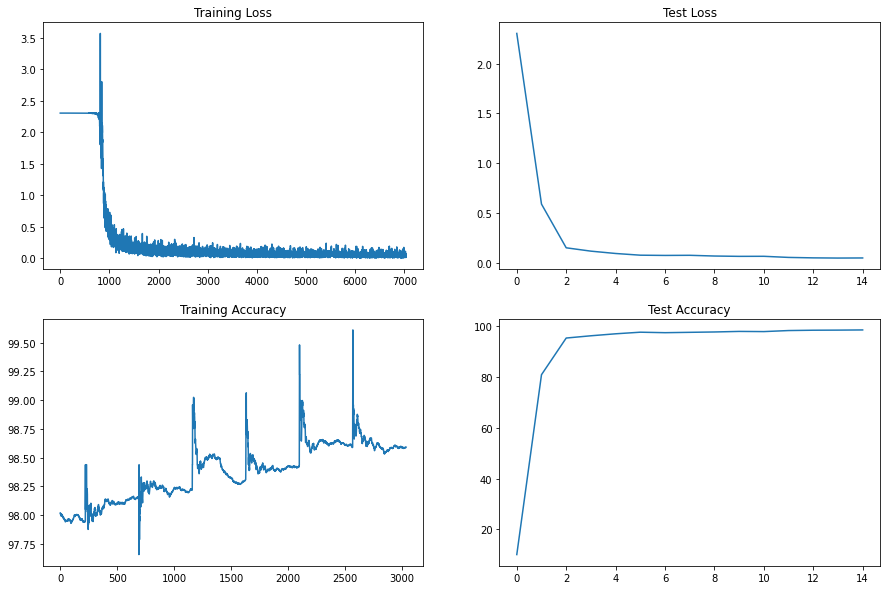

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")